In [26]:
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pyplot as pl

from interferometer import Interferometer
import jimgw
import lal

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import optax
import corner                            
#jax.config.update('jax_platform_name', 'cpu')

import distrax
import haiku as hk      #neural network library for JAX 
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple
Array = jnp.ndarray
PRNGKey = Array
OptState = Any

from curses import KEY_REPLACE
import lalsimulation as lalsim 
from jimgw.PE.detector_preset import * 
from jimgw.PE.detector_projection import make_detector_response

from jax.config import config
config.update("jax_enable_x64", True)

%matplotlib inline

In [27]:
f_min = 0. #minimum frequency cut-off
T = 1.  #data segment duration (8 seconds)
Fs = 20. #samplingfrequency  (Hz)
#t_start = 1126259446. #strain data segment start time 
t_start=0.
# since signals are generated in frequency domain this time is only used for calculating time dealys and hence is set to t_coalsecence

#initialise the detectors
H1_d = Interferometer('H1','O3',f_min,T,Fs,t_start,20011997)
L1_d = Interferometer('L1','O3',f_min,T,Fs,t_start,27071994)

In [28]:
def simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.cos(2*jnp.pi*f0*t) #time domain plus polarisation
    hct = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.sin(2*jnp.pi*f0*t) #time domain cross polarisation

    hp = jnp.fft.rfft(hpt) #frequency domain plus polarisation
    hc = jnp.fft.rfft(hct) #frequency domain cross polarisation

    return hp, hc

In [29]:
def simulate_fd_sine_gaussian_waveform_matrix(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = jnp.matmul(A.T,jnp.exp(-(t-t0)**2/tau**2)*jnp.cos(2*jnp.pi*f0*t)) #time domain plus polarisation
    hct = jnp.matmul(A.T,jnp.exp(-(t-t0)**2/tau**2)*jnp.sin(2*jnp.pi*f0*t)) #time domain cross polarisation

    hc = jnp.fft.rfft(hct) #frequency domain cross polarisation

    return hp, hc

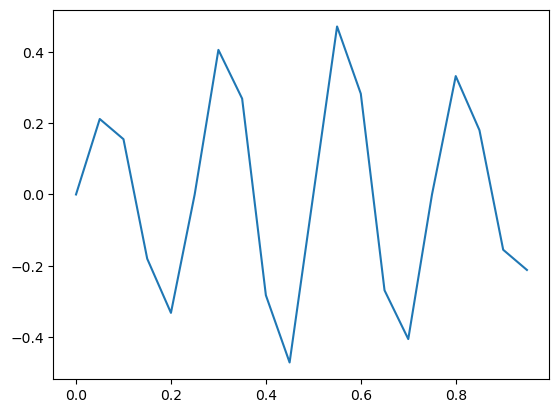

In [30]:
f0 = 4.
true_params = dict(
        A=0.5,
        t0=0.5,
        f0=4.,
        tau=2./f0,
        ra=0.5,
        dec=0.5,
        psi=0.5)

#simulate signal 
hp, hc = simulate_fd_sine_gaussian_waveform(true_params['A'], true_params['t0'], true_params['f0'], true_params['tau'], H1_d.times, f_min,H1_d.df)
hct = jnp.fft.irfft(hc)
pl.plot(H1_d.times,hct)

In [31]:
H1 = get_H1()
H1_response = make_detector_response(H1[0], H1[1])   #detector_response(f, hp, hc, ra, dec, gmst, psi), strain in freq domain
L1 = get_L1()
L1_response = make_detector_response(L1[0], L1[1])   

gps = lal.LIGOTimeGPS(true_params['t0'])
gmst_rad = lal.GreenwichMeanSiderealTime(gps)

L1_signal = L1_response(H1_d.freqs, hp, hc, true_params['ra'], true_params['dec'], gmst_rad, true_params['psi'])   
H1_signal = H1_response(H1_d.freqs, hp, hc, true_params['ra'], true_params['dec'], gmst_rad, true_params['psi'])

H1_noise = 0
L1_noise = 0

#H1_noise = noise_fd_dict['H1'][freqs>fmin]
H1_data = H1_noise + H1_signal

#L1_noise = noise_fd_dict['L1'][freqs>fmin]
L1_data = L1_noise + L1_signal

response = {'H1': H1_response, 'L1': L1_response}


In [32]:
def project_to_detector(detector, hp, hc, ra, dec, gmst_rad, psi):                   #unfix the frequency array?
    """Compute the response of the detector to incoming strain """
    return response[detector](H1_d.freqs, hp, hc, ra, dec, gmst_rad, psi)

In [52]:
test_params = dict(
        A = jnp.array([0.5,2.]),
        ra=jnp.array([0.5,1.]),
        dec=jnp.array([0.5,0.8]),
        psi=jnp.array([0.5,1.5]))

In [37]:
# likelihood function

class LogL(object):
    
    def __init__(self, true_gw_params):
        
        self.true_gw_params = true_gw_params
        self.detectors = {'H1': H1, 'L1': L1}
        
        gps_time = true_gw_params['t0']     #time of coalescence
        gps = lal.LIGOTimeGPS(gps_time)
        self.gmst_rad = lal.GreenwichMeanSiderealTime(gps)
        self.A = true_gw_params['A']
        self.t0 = true_gw_params['t0']
        self.f0 = true_gw_params['f0']
        self.tau = true_gw_params['tau']
        self.ra=true_gw_params['ra']
        self.dec = true_gw_params['dec']
        self.psi= true_gw_params['psi']

        self.f_min = 0.
        self.times = H1_d.times
        self.df = H1_d.df
        self.times2d = jnp.atleast_2d(H1_d.times)
        
        self.hp, self.hc = simulate_fd_sine_gaussian_waveform(self.A, self.t0, self.f0, self.tau, H1_d.times, self.f_min, H1_d.df)
        self.data = self.simulate_response(self.hp, self.hc, self.ra, self.dec, self.psi)
        

    def simulate_response_matrix(self, hp, hc, ra, dec, psi):
        # r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        r = {d: jnp.array([project_to_detector(d, hp[i], hc[i], ra[i], dec[i], self.gmst_rad, psi[i]) for i in range(len(ra))]) for d in self.detectors.keys()}
        return r
    
    def simulate_response(self, hp, hc, ra, dec, psi):
        r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        return r
    
    def __call__(self, params):
        hp, hc = simulate_fd_sine_gaussian_waveform(jnp.atleast_2d(params['A']).T, self.t0, self.f0, self.tau, self.times2d, self.f_min, self.df)
        # hp, hc = simulate_fd_sine_gaussian_waveform(params['A'], self.t0, self.f0, self.tau, self.times, self.f_min, self.df)
        
        #r = jnp.array([ self.simulate_response(hp, hc, params['ra'][i], params['dec'][i], params['psi'][i]) for i in range(len(params['ra']))])
        r = self.simulate_response_matrix(hp, hc, params['ra'], params['dec'], params['psi'])

        residuals = jnp.array([r[ifo] - self.data[ifo] for ifo in self.detectors.keys()])
        
        return -jnp.real(jnp.sum(residuals*jnp.conj(residuals),axis=(0,2)))/2

    @property
    def params(self):
        params = ['A','phi','dec','ra','psi']
        return params

    #@jax.jit
    def array_to_phys(self, x: Array) -> dict:
        
        p = dict()
        #p['A'] = x[:,0]
        #p['ra'] = (x[:,1]+1)*jnp.pi  #[0,2pi]
        #p['dec'] = (x[:,2])*jnp.pi/2  #[-pi/2,pi/2]
        #p['psi'] = (x[:,3]+1)*jnp.pi/2 #[0,pi]
        p['A'] = x[:,0]
        p['ra'] = x[:,1]  #[0,2pi]
        p['dec'] = x[:,2] #[-pi/2,pi/2]
        p['psi'] = x[:,3] #[0,pi]

        return p

In [38]:
#Neural network setup

from vi_routines import make_flow_model

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )

    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p) 

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_likelihood(x_flow)
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

In [53]:
n_params = 4
flow_num_layers = 4
hidden_size = 16
mlp_num_layers = 2
num_bins = 4


# perform variational inference
epochs = 100
loss = dict(train=[], val=[])
Nsamps = 20

learning_rate = 0.01
optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

prng_seq = hk.PRNGSequence(42)
key = next(prng_seq)
params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
opt_state = optimiser.init(params)

from tqdm import tqdm, trange
   
ldict = dict(loss = 0, T=1)

log_l = LogL(true_params)         

with trange(epochs) as tepochs:
    for epoch in tepochs:
  
        #update NN params (stochastic gradient descent with Adam optimiser)
        prng_key = next(prng_seq)
        loss = loss_fn(params,  prng_key, Nsamps)
        ldict['loss'] = f'{loss:.2f}'
        tepochs.set_postfix(ldict, refresh=True)
        params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)
            
            
        #print results every 50 iterations
        if epoch%50 == 0:
            print(f'Epoch {epoch}, loss {loss}')
            x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
            x_gen = np.array(x_gen, copy=False)
            p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
            truths = [log_l.true_gw_params[n] for n in ['A','ra','dec','psi']]
            fig = corner.corner(p_gen.T, labels=log_l.params, truths = truths)
            pl.show()

print("Done!")

x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
truths = [log_l.true_gw_params[n] for n in ['A','ra','dec','psi']]
fig = corner.corner(p_gen.T, truths = truths)
pl.show()

  0%|          | 0/100 [00:01<?, ?it/s, loss=20.57, T=1]


KeyboardInterrupt: 

In [48]:
x_gen

array([[0.65125776, 0.91375949, 0.88408384, 0.90245161],
       [0.3656907 , 0.91562218, 0.90132243, 0.88374958],
       [0.50628138, 0.79872265, 0.87581526, 0.92747123],
       ...,
       [0.62197129, 0.88308236, 0.06601426, 0.96166519],
       [0.55706527, 0.82766688, 0.42571002, 0.89522813],
       [0.77530931, 0.81090546, 0.05475978, 0.98780244]])

In [54]:
log_l(test_params)

Array([  -0.        , -115.26626676], dtype=float64)